# Neural Style Transfer.
#### Notes:
- When measuring content similarity, the lower layers tend to activate most highly when there is a pixel perfect match between the ***content_img*** and the generated ***input_img***.
-  A ***feature map*** is simply the post-activation output of a convolutional layer. For example, if a convolutional layer has 64 filters, it will output 64 feature maps.
- The ***Gram matrix*** measures the correlation (similarity) between each feature map and every other feature map in the layer, without necessarily caring about exact pixel positions.
- To visualize what each layer is most concerned with, we can set style_weight=0 and run the training process on a random input_img using different layers as the content_layer.
- In the case of ***style***, lower layers respond to small repetitive features while higher layers capture more abstract, global features. 
- We can use the same method we used for content to visualize the style each choice of layers is optimizing for. To do this, we set content_weight=0, specify which style_layers we want to use, and run the training process on a random input_img.


# Importing the necessary libraries.

In [40]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image, display

In [41]:
from tensorflow.python.keras.applications.vgg19 import VGG19, preprocess_input
from keras import backend as K

# Instantiating the VGG model object.

In [42]:
vgg_model = VGG19(include_top= False)
vgg_model.trainable = False

# Load Images using URL.

In [43]:
def get_content_and_style_image_paths(content_filename, style_filename, content_URL, style_URL):
    '''In case you need to fetch the images from the web, you can use these functions.'''
    content_image_path = keras.utils.get_file(content_filename, origin=content_URL)
    style_image_path = keras.utils.get_file(style_filename, origin = style_URL)
    return content_image_path, style_image_path

# For loading images from the local machine.

In [134]:
from google.colab import files
uploaded = files.upload()

Saving tajmahal.jpg to tajmahal.jpg
Saving abstract1.jpg to abstract1.jpg


# Final row and column numbers.

In [45]:
def get_nrows_and_ncols(from_URL = False, from_local = True, content_image_path = None, img_array = None):
    if from_URL:
        # Dimensions of the generated picture.
        width, height = keras.preprocessing.image.load_img(content_image_path).size
        img_nrows = 500
        img_ncols = int(width * img_nrows / height)
        return img_nrows, img_ncols

    elif from_local:
        # Dimensions of the generated picture.
        width, height = img_array.shape[0], img_array.shape[1]
        img_nrows = 500
        img_ncols = int(width * img_nrows / height)
        return img_nrows, img_ncols


In [61]:
# Temporary.
img_nrows, img_ncols = 500 , 500

# Load and process the image.

In [47]:
def load_and_preprocess_image(filename = '',image_path = None, img_nrows = 500):
    '''You need to upload the image first in the above cell in order to access the image using its filename.'''

    if image_path is not None:
        my_img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
        my_img = keras.preprocessing.image.img_to_array(my_img)

        # Dimensions of the generated picture.
#        width, height = my_img.size
#       img_ncols = int(width * img_nrows / height)

    else:
        im2 = keras.preprocessing.image.load_img(filename)
#        im2_array = keras.preprocessing.image.img_to_array(im2)

        # Dimensions of the generated picture.
#       width, height = im2_array.shape[0], im2_array.shape[1]
#       img_ncols = int(width * img_nrows / height)

        # Resize the picture.
        im2 = im2.resize(size=(img_nrows, img_ncols))
        my_img = keras.preprocessing.image.img_to_array(im2)


    my_img = np.expand_dims(my_img, axis = 0)   # Broadcasting the dimension for accomodating the number of examples.

    my_img = preprocess_input(my_img)
    #Preprocessed numpy.array or a tf.Tensor with type float32.
    #The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

    return my_img

# Deprocessing and displaying an image.

In [107]:
def deprocess(x):
    # performs the inverse of the preprocessing step.

#    img_nrows, img_ncols = get_nrows_and_ncols(from_local=True, img_array=x)
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image, title = None, size = (10, 8)):
    '''Don't Squeeze the array before use.'''
    if len(image.shape) == 4:                                                   # To remove the 1 from (1, n_H, n_C, n_C)
        img = np.squeeze(image, axis = 0)

    img = deprocess(img)
    
#    plt.figure(figsize = size)
    plt.grid(False)
    plt.axis(False)
    if title is not None:
      plt.title(title)
    plt.imshow(img)
    
    return

In [63]:
#display(Image(content_image_path))

In [64]:
#display(Image(style_image_path))

# Selecting the layers from the VGG - 19 model for content and style images.

In [86]:
style_layers = ['block1_conv1', 'block3_conv1','block4_conv1']
content_layers = 'block3_conv2'

# Intermidiate Models.
content_model = keras.models.Model(
    inputs = vgg_model.input,
    outputs = vgg_model.get_layer(content_layers).output
)

style_models = [keras.models.Model(inputs = vgg_model.input, outputs = vgg_model.get_layer(layer).output) for layer in style_layers]

# Model Summary.

In [ ]:
vgg_model.summary()

# Content Cost.

In [67]:
def content_cost(content, generated):
  a_C = content_model(content)
  a_G = content_model(generated)

  m, n_H, n_W, n_C = a_G.get_shape().as_list()
  a_C_unrolled = tf.reshape(a_C, (m, -1, n_C))
  a_G_unrolled = tf.reshape(a_G, (m, -1, n_C))
  
  cost = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
  return cost

# Style Cost.

In [68]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, (-1, channels))
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

In [116]:
# Setting the lambda hyper - parameter.

lamb = [1.0 , .8, .4, .2, .1]
#np.random.seed(100)
#lamb = np.random.rand(len(style_models))

lamb_dict = dict()
for style_model, lambdaa in zip(style_models, lamb):
    lamb_dict[style_model] = lambdaa
#lamb = .25

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)

        m, n_H, n_W, n_C = a_G.get_shape().as_list()

        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)

        current_layer_cost = tf.square(1 / (2 * n_H * n_W * n_C)) * (tf.reduce_mean(tf.square(GS - GG)))
        J_style += current_layer_cost * lamb_dict[style_model]
    
    return J_style

# Training Loop.

In [89]:
from time import time

generated_images = []

def training_loop(content_image_filename = '', style_image_filename = '',
                  content_image_path = None, style_image_path = None,
                  num_iterations = 20, content_weight = 10., style_weight = 20.,
                  learning_rate = 7.0, verbose = True):
 
  content_image = load_and_preprocess_image(filename = content_image_filename, image_path = content_image_path, img_nrows = 500)
  style_image = load_and_preprocess_image(filename = style_image_filename, image_path = style_image_path, img_nrows = 500)
  generated_image = tf.Variable(content_image, dtype = tf.float32)

  optimizer = keras.optimizers.Adam(learning_rate)

  best_cost = 1e+12 + 0.1
  best_image = None

  start_time = time()

  for ii in range(num_iterations):

    with tf.GradientTape() as tape:
      J_content = content_cost(content_image, generated_image)                  # Content image is a constant and the generated image is a variable like x in f(x).
      J_style = style_cost(style_image, generated_image)                        # Style image is a constant and the generated image is a variable like x in f(x).
      J_total = (content_weight * J_content) + (style_weight * J_style)

    grads = tape.gradient(J_total, generated_image)                             # Differentiating the total cost (J_total) w.r.t the variable generated_image.
    optimizer.apply_gradients([(grads, generated_image)])                       # Updates the weights in generated image.

    generated_images.append(generated_image.numpy())

    if (J_total < best_cost) and (ii != 0):
      best_cost = J_total
      best_image = generated_image.numpy()

    if verbose:
      if ii%2 == 0:
        stop_time = time()
        time_elapsed = stop_time - start_time

        print("Cost at step number "+ str(ii) + ' = ' + str(J_total) + ' \nTime Elapsed : ' + str(time_elapsed) + ' s.' )
        print()

  return best_image, best_cost

 # Training the model.

In [135]:
final_image, best_cost = training_loop(content_image_filename='tajmahal.jpg', style_image_filename='abstract1.jpg',
                                       num_iterations=50, content_weight = 0.1, style_weight = 1e6, learning_rate = 10.)

# Clearing the output after the processing is done.
from IPython.display import clear_output
clear_output()

# Displaying and saving the generated image alongside the content and style images.

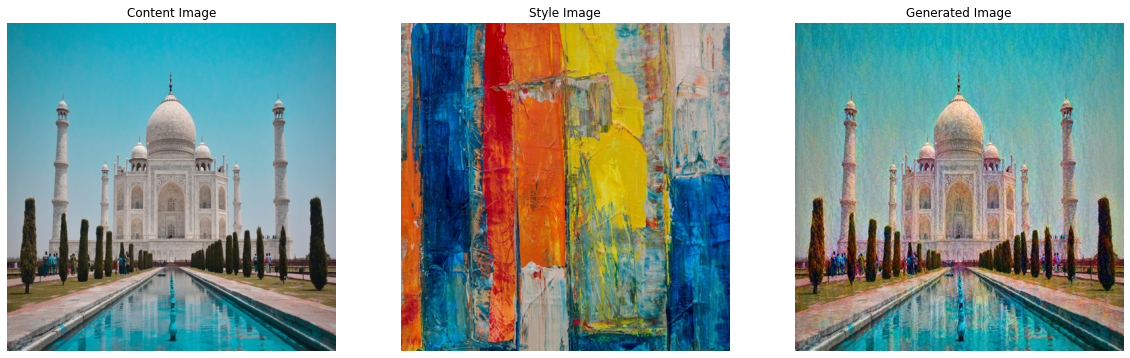

In [136]:
content  = load_and_preprocess_image(filename='tajmahal.jpg')
style = load_and_preprocess_image(filename='abstract1.jpg')

my_fig = plt.figure(figsize = (20,16))
plt.subplot(1,3,1)
plt.title('Content Image')
plt.axis(False)
plt.grid(False)
plt.imshow(deprocess(np.squeeze(content, axis = 0)))

plt.subplot(1,3,2)
plt.title('Style Image')
plt.axis(False)
plt.grid(False)
plt.imshow(deprocess(np.squeeze(style, axis = 0)))

plt.subplot(1,3,3)
plt.title('Generated Image')
plt.axis(False)
plt.grid(False)
plt.imshow(deprocess(np.squeeze(final_image, axis = 0)))

#plt.savefig('Dog_Abstract2.jpg', orientation = 'landscape', quality = 100)
#files.download('Dog_Abstract2.jpg')
#plt.savefig('dog_abstract2.pdf', orientation = 'landscape', quality = 100)
#files.download('dog_abstract2.pdf')

### Set 1: Satisfactory results. lr = 7.0, lambda = random
- content = face_portrait.jpg, style = abstract3.jpg
- style_layers = ['block1_conv1', 'block3_conv1','block4_conv1']
- content_layers = 'block3_conv2'